<a href="https://colab.research.google.com/github/maryam-sabet/KFold_DeepLearning_BinaryClassification_using_EnsembleMethod/blob/main/K_fold_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Change tensorflow version**

In [ ]:
!pip install tensorflow==2.9.1

# **Libraries**

In [ ]:
import glob
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet169,Xception,MobileNet,MobileNetV2,NASNetMobile,EfficientNetB0,DenseNet121,EfficientNetV2B0,ResNet50V2
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input,Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , CSVLogger , LearningRateScheduler
from sklearn.metrics import precision_score , recall_score , f1_score , confusion_matrix , ConfusionMatrixDisplay ,classification_report


In [ ]:
tf.__version__

'2.9.1'

# **Loading data**

In [ ]:
x_train =np.load("/content/drive/MyDrive/paper/K-fold code/dataset_npy/X_train_fold_1.npy",allow_pickle=True)
y_train=np.load("/content/drive/MyDrive/paper/K-fold code/dataset_npy/Y_train_fold_1.npy",allow_pickle=True)
x_test = np.load("/content/drive/MyDrive/paper/K-fold code/dataset_npy/X_test_fold_1.npy",allow_pickle=True)
y_test = np.load("/content/drive/MyDrive/paper/K-fold code/dataset_npy/Y_test_fold_1.npy",allow_pickle=True)


In [ ]:
print(x_train.shape ,y_train.shape ,x_test.shape , y_test.shape  )

(1120, 224, 224, 3) (1120,) (280, 224, 224, 3) (280,)


In [ ]:
# Shuffle the data
random.seed(1254)
combined = list(zip(x_train, y_train))
random.shuffle(combined)


x_train, y_train = zip(*combined)
y_train = np.array(y_train)
x_train = np.array(x_train)

In [ ]:
# Display class distribution
class_label = np.unique(y_train , return_counts=True)
print(class_label)

class_label[1][0]

(array(['Normal', 'patient'], dtype='<U7'), array([565, 555]))


565

# **Preprosesing for build the model...**

In [ ]:
# Label binarizing
lb = preprocessing.LabelBinarizer()

# Convert labels to categorical
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train , num_classes=2)

y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test , num_classes=2)

In [ ]:
print(x_train.shape ,y_train.shape ,x_test.shape , y_test.shape  )

(1120, 224, 224, 3) (1120, 2) (280, 224, 224, 3) (280, 2)


# **Models**

In [ ]:
# Define model checkpoint for saving best model during training
model_save = ModelCheckpoint("/content/drive/MyDrive/paper/K-fold code/ResNet50V2_kfold1.h5" , save_best_only=True , verbose=2 , monitor="val_accuracy" , mode="max" )


In [ ]:
# Load pre-trained ResNet50V2 model
base_model = ResNet50V2(weights="imagenet", include_top=False , input_tensor=Input(shape=(224,224,3)))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatting")(x)
x = Dense(128, activation='relu')(x)
x= Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# **preprocessing for fit model and fit**

In [ ]:
csv_loger = CSVLogger("/content/drive/MyDrive/paper/K-fold code/ResNet50V2_kfold1.csv" , append=True)

In [ ]:
# Define learning rate scheduler function
def set_decay(epoch):
  initAlpha =0.0008
  factor = 0.9
  dropEvery = 25
  aplpha = initAlpha * (factor**np.floor((1+epoch) / dropEvery))
  return float(aplpha)

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0008)
model.compile(optim , loss="categorical_crossentropy" , metrics=["accuracy"])


In [ ]:
batch_size = 8
TrainStep = len(x_train) / batch_size
ValStep = len(x_test) / batch_size

In [ ]:
x_train=x_train/255.0
x_test=x_test/255.0

In [ ]:
# generating with functions
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train = datagen.flow(x_train, y_train, batch_size=8)

In [ ]:
H = model.fit(train , epochs=15, callbacks=[model_save, csv_loger, LearningRateScheduler(set_decay)]
                        , validation_data = (x_test, y_test),shuffle=True )

Epoch 1/15
140/140 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8714
Epoch 1: val_accuracy improved from -inf to 0.74643, saving model to /content/drive/MyDrive/paper/K-fold code/ResNet50V2_kfold1.h5
140/140 [==============================] - 46s 251ms/step - loss: 0.3651 - accuracy: 0.8714 - val_loss: 4.1718 - val_accuracy: 0.7464 - lr: 8.0000e-04
Epoch 2/15
140/140 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.9107
Epoch 2: val_accuracy did not improve from 0.74643
140/140 [==============================] - 22s 159ms/step - loss: 0.2864 - accuracy: 0.9107 - val_loss: 1239.7527 - val_accuracy: 0.5179 - lr: 8.0000e-04
Epoch 3/15
140/140 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8714
Epoch 3: val_accuracy did not improve from 0.74643
140/140 [==============================] - 22s 159ms/step - loss: 0.3613 - accuracy: 0.8714 - val_loss: 1399.9542 - val_accuracy: 0.4536 - lr: 8.0000e-04
Epoch 4/15
140/140 [

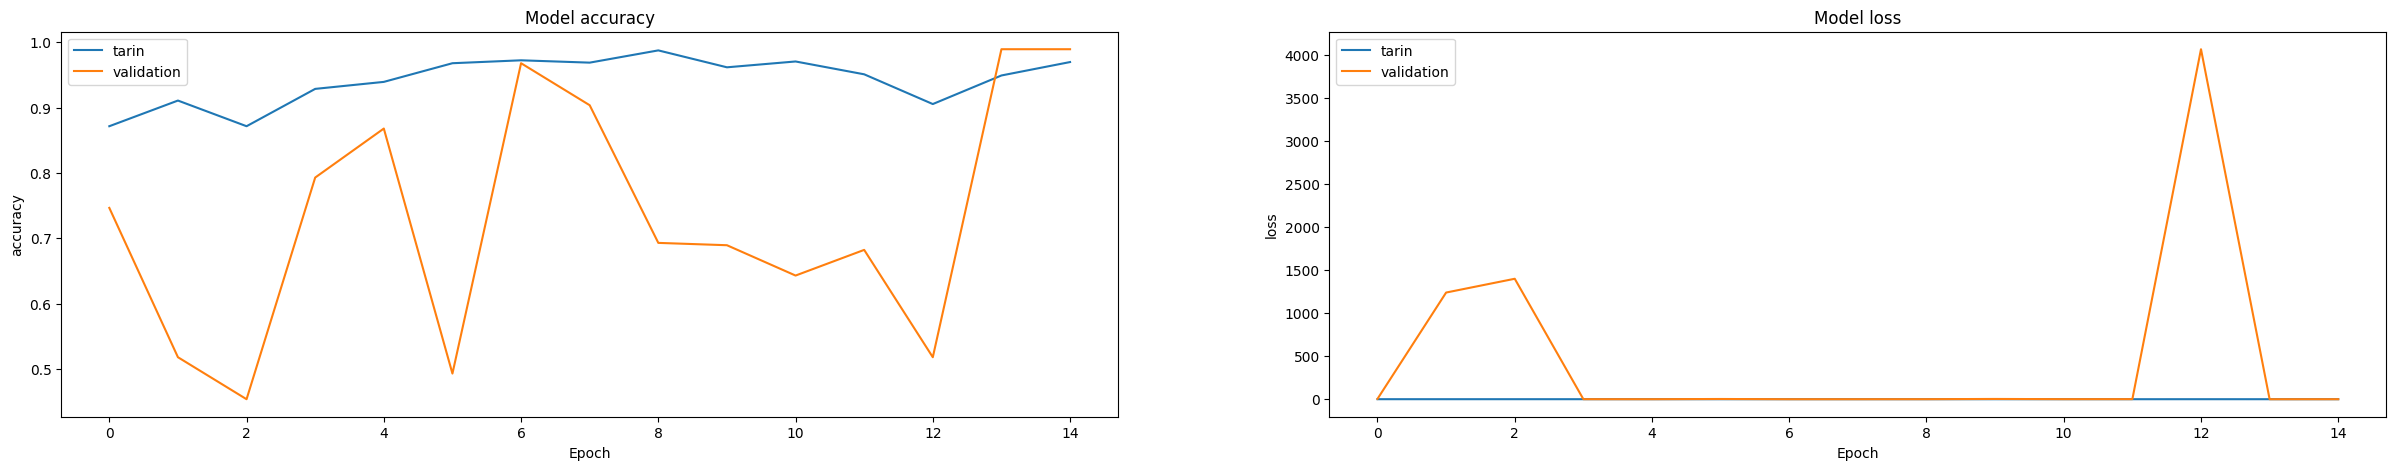

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(121)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.subplot(122)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/paper/K-fold code/ResNet50V2_kfold1.h5")

In [ ]:
#train
model.evaluate(x_train,y_train)

35/35 [==============================] - 4s 88ms/step - loss: 0.0522 - accuracy: 0.9830


[0.05216727778315544, 0.9830357432365417]

In [ ]:
#test
model.evaluate(x_test, y_test)

9/9 [==============================] - 2s 94ms/step - loss: 0.0190 - accuracy: 0.9893


[0.01902935467660427, 0.9892857074737549]

In [ ]:
prediction=model.predict(x_test)

9/9 [==============================] - 2s 93ms/step


In [ ]:
prediction=np.argmax(prediction,-1)
y_test=np.argmax(y_test,-1)

In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test , prediction ,  average="weighted")
print(precision*100)

98.95186335403727


In [ ]:
recal = recall_score(y_test , prediction ,  average="weighted")
print(recal*100)

98.92857142857143


In [ ]:
f1 = f1_score(y_test , prediction ,  average="weighted")
print(f1*100)

98.92885859784813


In [ ]:
print(classification_report(y_test , prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       135
           1       1.00      0.98      0.99       145

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



In [ ]:
# Generate confusion matrix
confusion_matrix(y_test , prediction)

array([[135,   0],
       [  3, 142]])

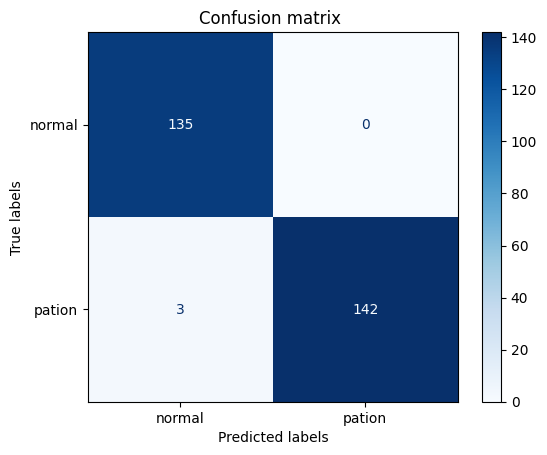

In [ ]:
cm=confusion_matrix(y_test , prediction)
target_names = ["normal" , "pation"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.title('Confusion matrix ')
plt.ylabel("True labels")
plt.show()